In [120]:
# @title
### EP2 MAC0417 / MAC5768
##################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP, #
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO     #
# DESTE EP.                                                      #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM,   #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM          #
# DESONESTIDADE ACADÊMICA OU PLÁGIO.                             #
#                                                                #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS        #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A          #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E        #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS    #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                           #
#                                                                #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO         #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR             #
# DESONESTIDADE ACADÊMICA.                                       #
#                                                                #
#                                                                #
# Nome : Vítor Garcia Comissoli                                  #
# NUSP : 11810411                                                #
# Turma: 2024145                                                 #
# Prof.: Ronaldo Fumio Hashimoto                                 #
##################################################################

# **EP02-2**

*   Vítor Garcia Comissoli - NUSP: 11810411

## **Links relevantes:**

*   Link para o GitHub: https://github.com/Vitor-Garcia-Comissoli/Codes_from_MAC0417
*   Link para a pasta do Google Drive: https://drive.google.com/drive/folders/1ubIiGba3zHnV96B1JR5jz7j8Usq4PoZH?usp=drive_link

## Carregamento das bibliotecas ##

In [121]:
import skimage
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import ndimage
from time import time
from skimage import io
from skimage.transform import resize
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from google.colab import drive
import os
import random

In [122]:
t00 = time()

In [123]:
#Coletor de lixo - otimiza a memória
gc.enable()

### **Input dos arquivos necessários:**

##### **Input pelo Google Drive:**
Inicialmente, deve ser criado um atalho da pasta do Google Drive (fornecida através do link anteriormente) para o Drive do usuário. Em seguida, através do código a seguir, o Google Colab é conectado ao Drive, é montada uma pasta e alterado o diretório da pasta.

##### **Input da pasta baixada localmente:**
Alternativamente, caso tenha baixado o .ipynb, estabelecer uma path para a pasta "EP01" (encontrada no repositório do GitHub), e renomeá-la "EPs".

In [124]:
# Montando a pasta:
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'

# Descomentar essa linha, e comentar a anterior, após copiar a pasta para o drive pessoal:
# path = '/content/gdrive/My Drive/EPs'

# Descomentar essa linha, e comentar as anteriores, para usar o arquivo baixado nativamente:
# path = 'F:/Downloads/EPs'

# Alterando o diretório:
import os
os.chdir(path)

# Listando os arquivos do diretório:
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 Anel		     EP01.ipynb        Lapiseira		     Mouse
 augmentedDataset    EP02-1.ipynb      Metadados_atualizado.gsheet   normalizedDataset
 Caneta		     EP02-2.ipynb      Metadados_atualizado.xlsx     originalGrayDataset
 Canivete	    'Fone Bluetooth'   Metadados.gsheet		     Pendrive
'Carta de Baralho'   Lápis	       Metadados.xlsx		    'SD Card'


## Metadados ##

In [125]:
# Tabela principal:
metadados = pd.read_excel('Metadados.xlsx')
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [126]:
#Tabela com as informações das classes
classes = pd.read_excel('Metadados.xlsx', sheet_name='Classe')
classes

index  codigo              desc abrv
0      0       1             Mouse    M
1      1       2           SD Card   SD
2      2       3         Lapiseira  LSR
3      3       4            Caneta  CNT
4      4       5             Lápis  LPS
5      5       6          Pendrive   PD
6      6       7          Canivete  CNV
7      7       8              Anel    A
8      8       9  Carta de Baralho   CB
9      9      10    Fone Bluetooth   FB

## 0. Importando filtros do EP2-1 ##

In [127]:
def rgbparacinza(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem RGB e a transforma para uma imagem em níveis de cinza.
  Além disso, reduz as dimensões da imagem para metade das dimensões originais
  e retorna um numpy.ndarray com 8-bits por pixel, ou seja, do tipo np.uint8.

  Dependências: skimage, skimage.transform.resize, numpy as np
  '''

  # Converte para níveis de cinza:
  im_cinza = skimage.color.rgb2gray(imagem)

  # Aplica o resize - diminuindo para metade das dimensões originais:
  im_cinza = resize(im_cinza, output_shape = (im_cinza.shape[0]//2,im_cinza.shape[1]//2), anti_aliasing = False)

  # Muda o tipo de dado para np.uint8:
  im_cinza = skimage.util.img_as_ubyte(im_cinza)

  return im_cinza

In [128]:
def contrast_stretching(imagem):
  '''
  (numpy.ndarray,numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o contrast streching por meio da operação:
  OUTPUT = (IMAGEM - MIN(IMAGEM)) * STRETCH, onde STRETCH = 255 / MAX(IMAGEM - MIN(IMAGEM))

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage.
  '''

  # Obtendo as intensidades máxima e mínima da imagem:
  min = imagem.min()
  max = imagem.max()

  # Translocando a imagem para que a intensidade mínima seja 0:
  out = (imagem - min)

  # Obtendo o valor a ser "streatched":
  stretch = 255 / (out.max())

  # Realizando o streatching:
  out = out * stretch

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

In [129]:
def logaritmo_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o logaritmo natural da imagem por meio da operação:

  OUTPUT = LN(1+INPUT)

  Na equação acima, INPUT é convertido internamente para o range(0,1).

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: skimage, numpy as np
  '''

  # Aplica a transformação logarítmica:
  out = skimage.exposure.adjust_log(imagem)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

In [130]:
def exponencial_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o logaritmo natural da imagem por meio da operação:

  OUTPUT = exp(INPUT)

  Na equação acima, INPUT é convertido internamente para o range(0,1).

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage, math
  '''

  # Aplica a função OUT = 255 * (exp(IN/255)-1)/(e-1):
  out = 255*(np.exp(imagem/255, dtype = np.float64)-1)/(math.e-1)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

In [131]:
def laplaciano_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornado o laplaciano da imagem calculada através da convolução com um kernel de 4 vizinhos:

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage, cv2
  '''

  # Calcula o laplaciano usando um kernel de 4 vizinhos:
  out = cv2.Laplacian(imagem, cv2.CV_64F, ksize=1)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

In [132]:
def filtro_media(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornado o filtro da média da imagem de entrada usando convolução,
  uma janela de dimensões 9x9 e zero-padding.

  Dependências: numpy as np, scipy.ndimage, skimage
  '''

  # Matriz de pesos ('weights'):
  k = np.full(shape = (9,9), fill_value = 1/81)

  # Aplica a convolução:
  out = ndimage.convolve(input = imagem, weights = k, mode = 'constant', cval = 0.0)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 0.1 Função base de normalização ##
A função de normalização utilizada foi a de equalização de histograma e baseia-se na função nativa do skimage, equalize_hist, cuja documentação pode ser acessada através do link:
https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist


In [133]:
def equalizar_vc(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada a imagem normalizada por meio da operação de equalização de histo-
  gramas.

  Dependências: numpy as np, scipy.ndimage, skimage
  '''

  # Aplica a equalização de histograma:
  out = skimage.exposure.equalize_hist(imagem)*255

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 0.3 Algumas variáveis globais ##

In [134]:
diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs/'

lista_extensoes = ['med','exp','log','lap','con']

todas_transf = ['cin', 'exp', 'log', 'lap', 'med', 'con', 'norm']

lista_filtros = [contrast_stretching, logaritmo_imagem, exponencial_imagem, laplaciano_imagem, filtro_media]

filtros = {rgbparacinza: 'cin', contrast_stretching: 'con', logaritmo_imagem:'log',
           exponencial_imagem: 'exp', laplaciano_imagem: 'lap', filtro_media:'med', equalizar_vc: 'norm'}

## 0.4 Importando funções gerais do EP2-1 ##

A função 'aplica_filtro' foi ligeiramente alterada para comportar a transformação de normalização.

In [135]:
def cria_dataset(diretorio_original, tipo):
  ''' (str, str) -> None
  Essa função recebe duas strings: diretorio_original e tipo. Ela simplesmente
  cria uma pasta com o nome 'tipo' dentro de diretorio_original. Os valores que
  'tipo' irá receber são diversos: originalGrayDataset, augmentedDataset,
  normalizedDataset, os nomes das diferentes classes (Anel, Copo, etc) ou dos
  filtros específicos (Exp, Log, Norm, Grad, Med).
  Dependência: os
  '''

  if not os.path.exists(diretorio_original + tipo):
    path = diretorio_original+tipo
    os.makedirs(path)


In [136]:
def aplica_filtro(tipo_filtro , diretorio_original, diretorio_final, classe, dicionario_filtros = filtros, extensao_norm = 'cin'):
  ''' (function, str, str, str,dict) -> None.
  Essa função é o coração do EP. A mesma recebe uma função de filtro ('tipo_filtro')
  e aplica a mesma para todas as imagens da classe 'classe' que estiverem na
  pasta 'diretorio_original', escrevendo-as na pasta 'diretorio_final'.

  No ato de aplicar os filtros, essa função utiliza o dicionário 'dicionario_filtros'
  para criar pastas com os nomes das transformações dentro das pastas das classes
  no 'diretorio_final', além de escrever as extensões corretas no nome final.

  No caso da transformação em níveis de cinza, não foi criada uma nova pasta nos
  diretórios de classes por ser considerada supérflua.

  Exemplo de aplicação 1:
  >>> aplica_filtro(tipo_filtro = rgbparacinza,
  diretorio_original = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs',
  diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/originalGrayDataset/',
  classe = 'Anel')
  #Lê todas as imagens que estiverem na pasta '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/Anel'
  #Aplica a transformação rgbparacinza em cada imagem com nome, por ex., 'exemplo.jpg'
  #Acessa a chave correspondente a rgbparacinza em dicionario_filtros (padrão: 'cin')
  #Escreve a imagem transformada na pasta '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/originalGrayDataset/Anel'
  #Com o nome 'exemplo-cin.jpg'

  Exemplo de aplicação 2:
  >>> aplica_filtro(tipo_filtro = logaritmo_imagem,
  diretorio_original = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/originalGrayDataset/',
  diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/augmentedDataset/',
  classe = 'Anel')
  #Lê todas as imagens que estiverem na pasta '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/originalGrayDataset/Anel/'
  #Aplica a transformação logaritmo_imagem em cada imagem com nome, por ex., 'exemplo-cin.jpg'
  #Acessa a chave correspondente a logaritmo_imagem em dicionario_filtros (padrão: 'log')
  #Escreve a imagem transformada na pasta '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/augmentedDataset/Anel/log/'
  #Com o nome 'exemplo-cin-log.jpg'

  Dependências: gc, time.time, from pathlib import Path, skimage.io, os, skimage, random.choice
  '''

  # Coletor automático de lixo:
  gc.enable()

  # Tempo para aplicação da função:
  t0 = time()

  # Transformando a string do diretório de entrada em um objeto Path:
  if (tipo_filtro == equalizar_vc) and extensao_norm != 'cin':
    folder_entrada = Path(f"{diretorio_original}/")
  else:
    folder_entrada = Path(f"{diretorio_original}/{classe}/")

  # Extensão dos arquivos e nomes das novas pastas:
  extensao = dicionario_filtros[tipo_filtro]

  # Listando as imagens na pasta original:
  nomes_imagens = os.listdir(folder_entrada)

  # Criando e nomeando a nova pasta:
  if tipo_filtro == rgbparacinza:
    # Se a transformação for para níveis de cinza, não é necessário usar a extensão
    cria_dataset(diretorio_final, f"/{classe}")
    nova_pasta = Path(f"{diretorio_final}/{classe}/")

  elif tipo_filtro == equalizar_vc:
    # Se a transformação for de normalização, o folder de saída muda um pouco
    cria_dataset(diretorio_final, f"{classe}/{extensao_norm}/")
    nova_pasta = Path(f"{diretorio_final}/{classe}/{extensao_norm}/")

  else:
    cria_dataset(diretorio_final, f"{classe}/{extensao}/")
    nova_pasta = Path(f"{diretorio_final}/{classe}/{extensao}/")

  for nome_imagem in nomes_imagens:
    # Lendo a imagem de entrada:
    imagem_entrada = io.imread(f"{folder_entrada}/{nome_imagem}")

    # Aplicando o filtro:
    imagem_saida = tipo_filtro(imagem_entrada)

    # Escrevendo a imagem de saída no diretório correto com a extensão correta:
    os.chdir(nova_pasta)
    io.imsave(f"{nome_imagem[:-4]}-{extensao}.jpg", imagem_saida)

    del imagem_entrada, imagem_saida

  del nomes_imagens

  # Tempo para aplicação da função:
  t1 = time()
  print(f"Tempo para aplicação do filtro '{extensao}' para a pasta {folder_entrada}: {(t1-t0):.3f}s")

## 1. Criação do normalizedDataSet ##

Para a criação do normalizedDataSet, é necessário aplicar apenas uma função para cada uma das pastas do augmentedDataSet e do
originalGrayDataset.


In [137]:
# Criando a pasta do 'normalizedDataset':
cria_dataset(diretorio_final,'normalizedDataset' )

In [138]:
# Aplicando a normalização para as imagens em níveis de cinza:
Parallel(n_jobs=-1, verbose = 1)(delayed(aplica_filtro)(tipo_filtro = equalizar_vc,
  diretorio_original = f"{diretorio_final}/originalGrayDataset/",
  diretorio_final = f"{diretorio_final}/normalizedDataset/",
  classe = classe,
  extensao_norm = 'cin') for classe in classes['desc'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


[None, None, None, None, None, None, None, None, None, None]

In [139]:
# Aplicando a normalização para as demais transformações:
for extensao in lista_extensoes:
  Parallel(n_jobs=-1, verbose = 1)(delayed(aplica_filtro)(tipo_filtro = equalizar_vc, diretorio_original = f"{diretorio_final}/augmentedDataset/{classe}/{extensao}", diretorio_final = f"{diretorio_final}/normalizedDataset/" , classe = classe, extensao_norm = extensao) for classe in classes['desc'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished


## 2. Atualização do arquivo de metadados ##


Para a atualização do arquivo de metadados, criou-se um novo arquivo .xlsx nomeado "Metadados_atualizado.xlsx", onde os novos metadados foram adicionados a uma coluna chamada "transformacao" na folha "Metadados".

### Transformações:
* org - Imagem colorida original
* cin - Imagem em escala de cinza
* exp - Imagem que passou pela operação exponencial
* con - Imagem que passou pelo contrast stretching
* log - Imagem que passou pela operação logaritmica
* lap - Imagem que passou pela operação laplaciana
* med - Imagem que passou pela operação de convolução pelo filtro da média
* norm - Imagem que passou pela operação de normalização de histograma

In [140]:
# Leitura da tabela contendo os códigos das transformações aplicadas às imagens:
%load_ext google.colab.data_table
transf = pd.read_excel('Metadados_atualizado.xlsx', sheet_name='Transformacao')
transf

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


codigo                                          descricao
0    org                           imagem colorida original
1    cin                          imagem em escala de cinza
2    exp        imagem que passou pela operacao exponencial
3    con         Imagem que passou pelo contrast stretching
4    log        imagem que passou pela operacao logaritmica
5    lap         imagem uqe passou pela operação laplaciana
6    med  imagem que passou pela operacao de convolucao ...
7   norm  imagem que passou pela operacao de normalizaca...

In [141]:
# Leitura da tabela Metadados atualizada:
%load_ext google.colab.data_table
metadados_atualizado = pd.read_excel('Metadados_atualizado.xlsx')
metadados_atualizado

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


index               name_jpg  class  obj_number  repeticao  \
0         1                A_ama_1      1           1          1   
1         2                A_bra_1      1           1          1   
2         3                A_esc_1      1           1          1   
3         4               A_roxo_1      1           1          1   
4         5                B_ama_1      1           1          1   
...     ...                    ...    ...         ...        ...   
6235   6236  C_roxo_3-cin-med-norm     10           1          3   
6236   6237   P_ama_3-cin-med-norm     10           1          3   
6237   6238   P_bra_3-cin-med-norm     10           1          3   
6238   6239   P_esc_3-cin-med-norm     10           1          3   
6239   6240  P_roxo_3-cin-med-norm     10           1          3   

      plano_de_fundo  iluminacao transformacao  
0                  4           4           org  
1                  4           2           org  
2                  4           1           org  
3                  4           3           org  
4                  2           4           org  
...              ...         ...           ...  
6235               3           3  cin-med-norm  
6236               1           4  cin-med-norm  
6237               1           2  cin-med-norm  
6238               1           1  cin-med-norm  
6239               1           3  cin-med-norm  

[6240 rows x 8 columns]

## 3. Histograma médio antes e depois da normalização de cada iluminação ##

Para a obtenção dos histogramas, tanto da database pré normalização, como da database normalizada, dada a iluminação como a variável a ser comparada, deve-se obter primeiramente o protótipo médio, que é a imagem que, fixada a iluminação e o método (cinza, exponencial, laplaciano, etc) soma todas as intensidades de todos os pixels de cada uma das imagens que contem essas características (como, por exemplo, sem iluminação e que utilizou o contrast stretching) e divide pelo número de imagens que tinham aquelas características (o que seria, em termos leigos, a "média" das imagens).

Obtido esse protótipo médio, para a obtenção dos histogramas, deve-se usar as intensidades dos pixels dessa imagem, onde o eixo x representa as intensidades dos pixels (de 0 a 255) e o eixo y representa a quantidade de pixels que possuem aquela intensidade.

In [142]:
# Não tive tempo de finalizar o código referente a elaboração e ao plot desses histrogramos, visto que todas as minhas tentativas de realizar a obtenção
# das imagens de protótipo médio levavam a erros de dimensionalidade das imagens, erros esses que eu não entendi o porque estavam acontecendo e, dado isso,
# não tive como entendê-los para poder resolvê-los. Para não atrapalhar a execução do restante do notebook, resolvi optar por retirar as chamadas para as
# funções que plotam as imagens e os gráficos, visto que elas não estão funcionando como deveriam, mas as funcões em sí ainda estão presentes no notebook,
# para demostrar o progresso e as horas de trabalho dedicadas a elas.

In [143]:
def prototipos_medios(classe, tipo_transf, folder_pai = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs/originalGrayDataset', class_df = classes, extensao_norm = 'cin'):
  ''' (str, str, str, pandas.dataframe, str) -> numpy.ndarray , numpy.ndarray, numpy.ndarray
  Essa função recebe uma str classe, que contém o nome de um determinado tipo
  de iluminação dos objetos.
  Recebe, ainda, uma str tipo_transf, que contém as iniciais da transformação
  referente ao dataset original. A variável tipo_transf pode assumir os valores
  'cin', 'exp', 'log', 'lap', 'med', 'con' e 'norm'.

  Quando tipo_transf == 'norm', é necessária a variável 'extensao_norm',
  que assume os valores 'cin', 'exp', 'med', 'log', 'lap' ou 'con'.

  A variável folder_pai representa o diretório que contém as pastas das classes.

  Retorna-se o protótipo médio da iluminação após aplicada a transformação
  'tipo_transf', o histograma médio da iluminação, representado por
  seus vetores de médias e variâncias.

  Dependências: gc, time.time, pathlib.Path, os, skimage, numpy as np, pandas,
  skimage.io, matplotlib.pyplot as plt
  '''

  # Coletor automático de lixo:
  gc.enable()

  # Tempo para aplicação da função:
  t0 = time()

  # Transformando a string em um objeto Path:
  if tipo_transf == 'norm':
    folder_entrada = Path(f"{folder_pai}/{classe}/{extensao_norm}")
  elif tipo_transf == 'cin':
    folder_entrada = Path(f"{folder_pai}/{classe}")
  else:
    folder_entrada = Path(f"{folder_pai}/{classe}/{tipo_transf}")

  nomes_imagens = os.listdir(folder_entrada)
  tamanho_folder = len(nomes_imagens)
  # Imagem-base para fazer o protótipo médio:
  sample_image = io.imread(f"{folder_entrada}/{nomes_imagens[0]}")
  prot_med = np.zeros(shape = sample_image.shape)
  del sample_image
  # Cada linha de 'todos_histogramas' é o histograma de uma imagem
  todos_histogramas = np.zeros(shape = (tamanho_folder, 256))
  for i in range(len(nomes_imagens)):
    nome_imagem = nomes_imagens[i]
    # Lendo a imagem em níveis de cinza:
    im_cinza = io.imread(f"{folder_entrada}/{nome_imagem}")

    # Histograma da imagem em níveis de cinza:
    contagens, bins = np.histogram(im_cinza, bins=256)
    todos_histogramas[i,:] =  contagens

    # Protótipo médio:
    prot_med = np.add(prot_med,im_cinza/tamanho_folder)

    del im_cinza, bins, nome_imagem

  # Média e variância dos histogramas:
  medias = np.mean(todos_histogramas, axis = 0)
  variancias = np.var(todos_histogramas, axis = 0)

  del nomes_imagens, todos_histogramas
  t1 = time()
  print(f"Tempo de execução das estatísticas médias para a pasta {folder_entrada}: {(t1-t0):.3f}s")

  return np.array(prot_med, dtype = np.uint8), medias, variancias

In [144]:
def aplica_protmedio_classe(classe, diretorio):
  ''' (str, str) -> list, list, list
  Essa função recebe uma str 'classe' e um diretorio 'diretorio' e retorna três
  listas: uma de protótipos médios, uma das médias dos histogramas médios e uma
  das variâncias dos histogramas médios para cada uma das 12 transformações.
  São elas:
    1. Original em níveis de cinza
    2. Exponencial (aplicada a 1)
    3. Logaritmo (aplicada a 1)
    4. Laplaciano (aplicada a 1)
    5. Filtro da média (aplicada a 1)
    6. Contrast strecthing (aplicada a 1)
    7. Normalização (aplicada a 1)
    8. Normalização (aplicada a 2)
    9. Normalização (aplicada a 3)
    10. Normalização (aplicada a 4)
    11. Normalização (aplicada a 5)
    11. Normalização (aplicada a 6).
  Dependências: gc, prothist, numpy as np
  '''

  # Coletor automático de lixo:
  gc.enable()

  # Calculando as estatísticas para o originalGrayDataset:
  estatisticas_gray = prototipos_medios(classe = classe, tipo_transf = 'cin' , folder_pai = f"{diretorio}/originalGrayDataset")
  # Calculando as estatísticas para o augmentedDataset:
  estatisticas_augmented = Parallel(n_jobs=-1, verbose = 1)(delayed(prototipos_medios)(classe = classe, tipo_transf = transf , folder_pai = f"{diretorio}/augmentedDataset") for transf in todas_transf[1:-1])
  # Calculando as estatísticas para todas as transformações do normalizedDataset:
  estatisticas_normalized = Parallel(n_jobs=-1, verbose = 1)(delayed(prototipos_medios)(classe = classe, tipo_transf = 'norm' , folder_pai = f"{diretorio}/normalizedDataset", extensao_norm = transf) for transf in todas_transf[:-1])

  # As listas seguintes armazenarão os valores finais dos protótipos médios,
  # médias dos histogramas médios e variãncias dos histogramas médios:
  lista_prot, lista_hist, lista_var = [],[],[]

  lista_prot.append(estatisticas_gray[0])
  lista_hist.append(estatisticas_gray[1])
  lista_var.append(estatisticas_gray[2])

  for transformacao in range(len(estatisticas_augmented)):
    lista_prot.append(estatisticas_augmented[transformacao][0])
    lista_hist.append(estatisticas_augmented[transformacao][1])
    lista_var.append(estatisticas_augmented[transformacao][2])

  for transformacao in range(len(estatisticas_normalized)):
    lista_prot.append(estatisticas_normalized[transformacao][0])
    lista_hist.append(estatisticas_normalized[transformacao][1])
    lista_var.append(estatisticas_normalized[transformacao][2])

  del estatisticas_gray, estatisticas_augmented, estatisticas_normalized

  return lista_prot, lista_hist, lista_var

In [145]:
def grafico(lista_prototipos_medios, lista_histogramas_medios, lista_variancias_medias, x = np.arange(0,256)):
  '''
  (list, list,list, numpy.ndarray) -> None
  Essa função recebe três listas: uma de protótipos médios, uma das médias dos
  histogramas médios e uma das variâncias dos histogramas médios para cada uma
  das 12 transformações. Faz uma visualização conjunta
  dos mesmos com o padrão MNIST e barras de erros.
  Dependências: matplotlib.pyplot as plt
  '''

  titulos = [ "Níveis de cinza", "Exponencial","Logaritmo", "Laplaciano", "Contrast strecthing", "Filtro da média"]
  metade = len(lista_histogramas_medios)//2
  lista_desvpad = []

  for i in range(len(lista_variancias_medias)):
    lista_desvpad.append(np.sqrt(lista_variancias_medias[i]))

  fig, axs = plt.subplots(12, 3, figsize=(25, 40))

  for i in range(12):
    axs[i,0].imshow(lista_prototipos_medios[i], cmap='gray',vmin=0, vmax=255)
    axs[i,0].axis('off')
    axs[i,1].bar(x = x, height = lista_histogramas_medios[i])
    axs[i,2].errorbar(x = x, y = lista_histogramas_medios[i], yerr = lista_desvpad[i])
    if i < metade:
      axs[i,0].set_title(f"{titulos[i]}: Protótipo médio")
      axs[i,1].set_title(f"{titulos[i]}: Histograma médio")
      axs[i,2].set_title(f"{titulos[i]}: Histograma médio com variâncias")
    else:
      axs[i,0].set_title(f"{titulos[i-metade]} Norm: Protótipo médio")
      axs[i,1].set_title(f"{titulos[i-metade]} Norm: Histograma médio")
      axs[i,2].set_title(f"{titulos[i-metade]} Norm: Histograma médio com variâncias")
  plt.show()
  plt.tight_layout()

## 4. Comparação entre imagens antes e depois da normalização ##

Apresentou-se então imagens do antes e depois da normalização realizada, dados os 4 tipos de iluminação, abreviados segundo a legenda abaixo.

### Legenda:
* S - Sem iluminação
* B - Iluminação branca
* R - Iluminação roxa
* A - Iluminação amarelada

In [146]:
# Leitura da tabela contendo as abreviações dos tipos de iluminação:
%load_ext google.colab.data_table
ilum = pd.read_excel('Metadados_atualizado.xlsx', sheet_name='Iluminacao')
ilum

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


index  codigo                  desc abrv
0      0       1        Sem Iluminação    S
1      1       2     Iluminação Branca    B
2      2       3       Iluminação Roxa    R
3      3       4  Iluminação Amarelada    A

Rodando uma adaptação do plot presente no EP02-1, para o Dataset não normalizado, temos:

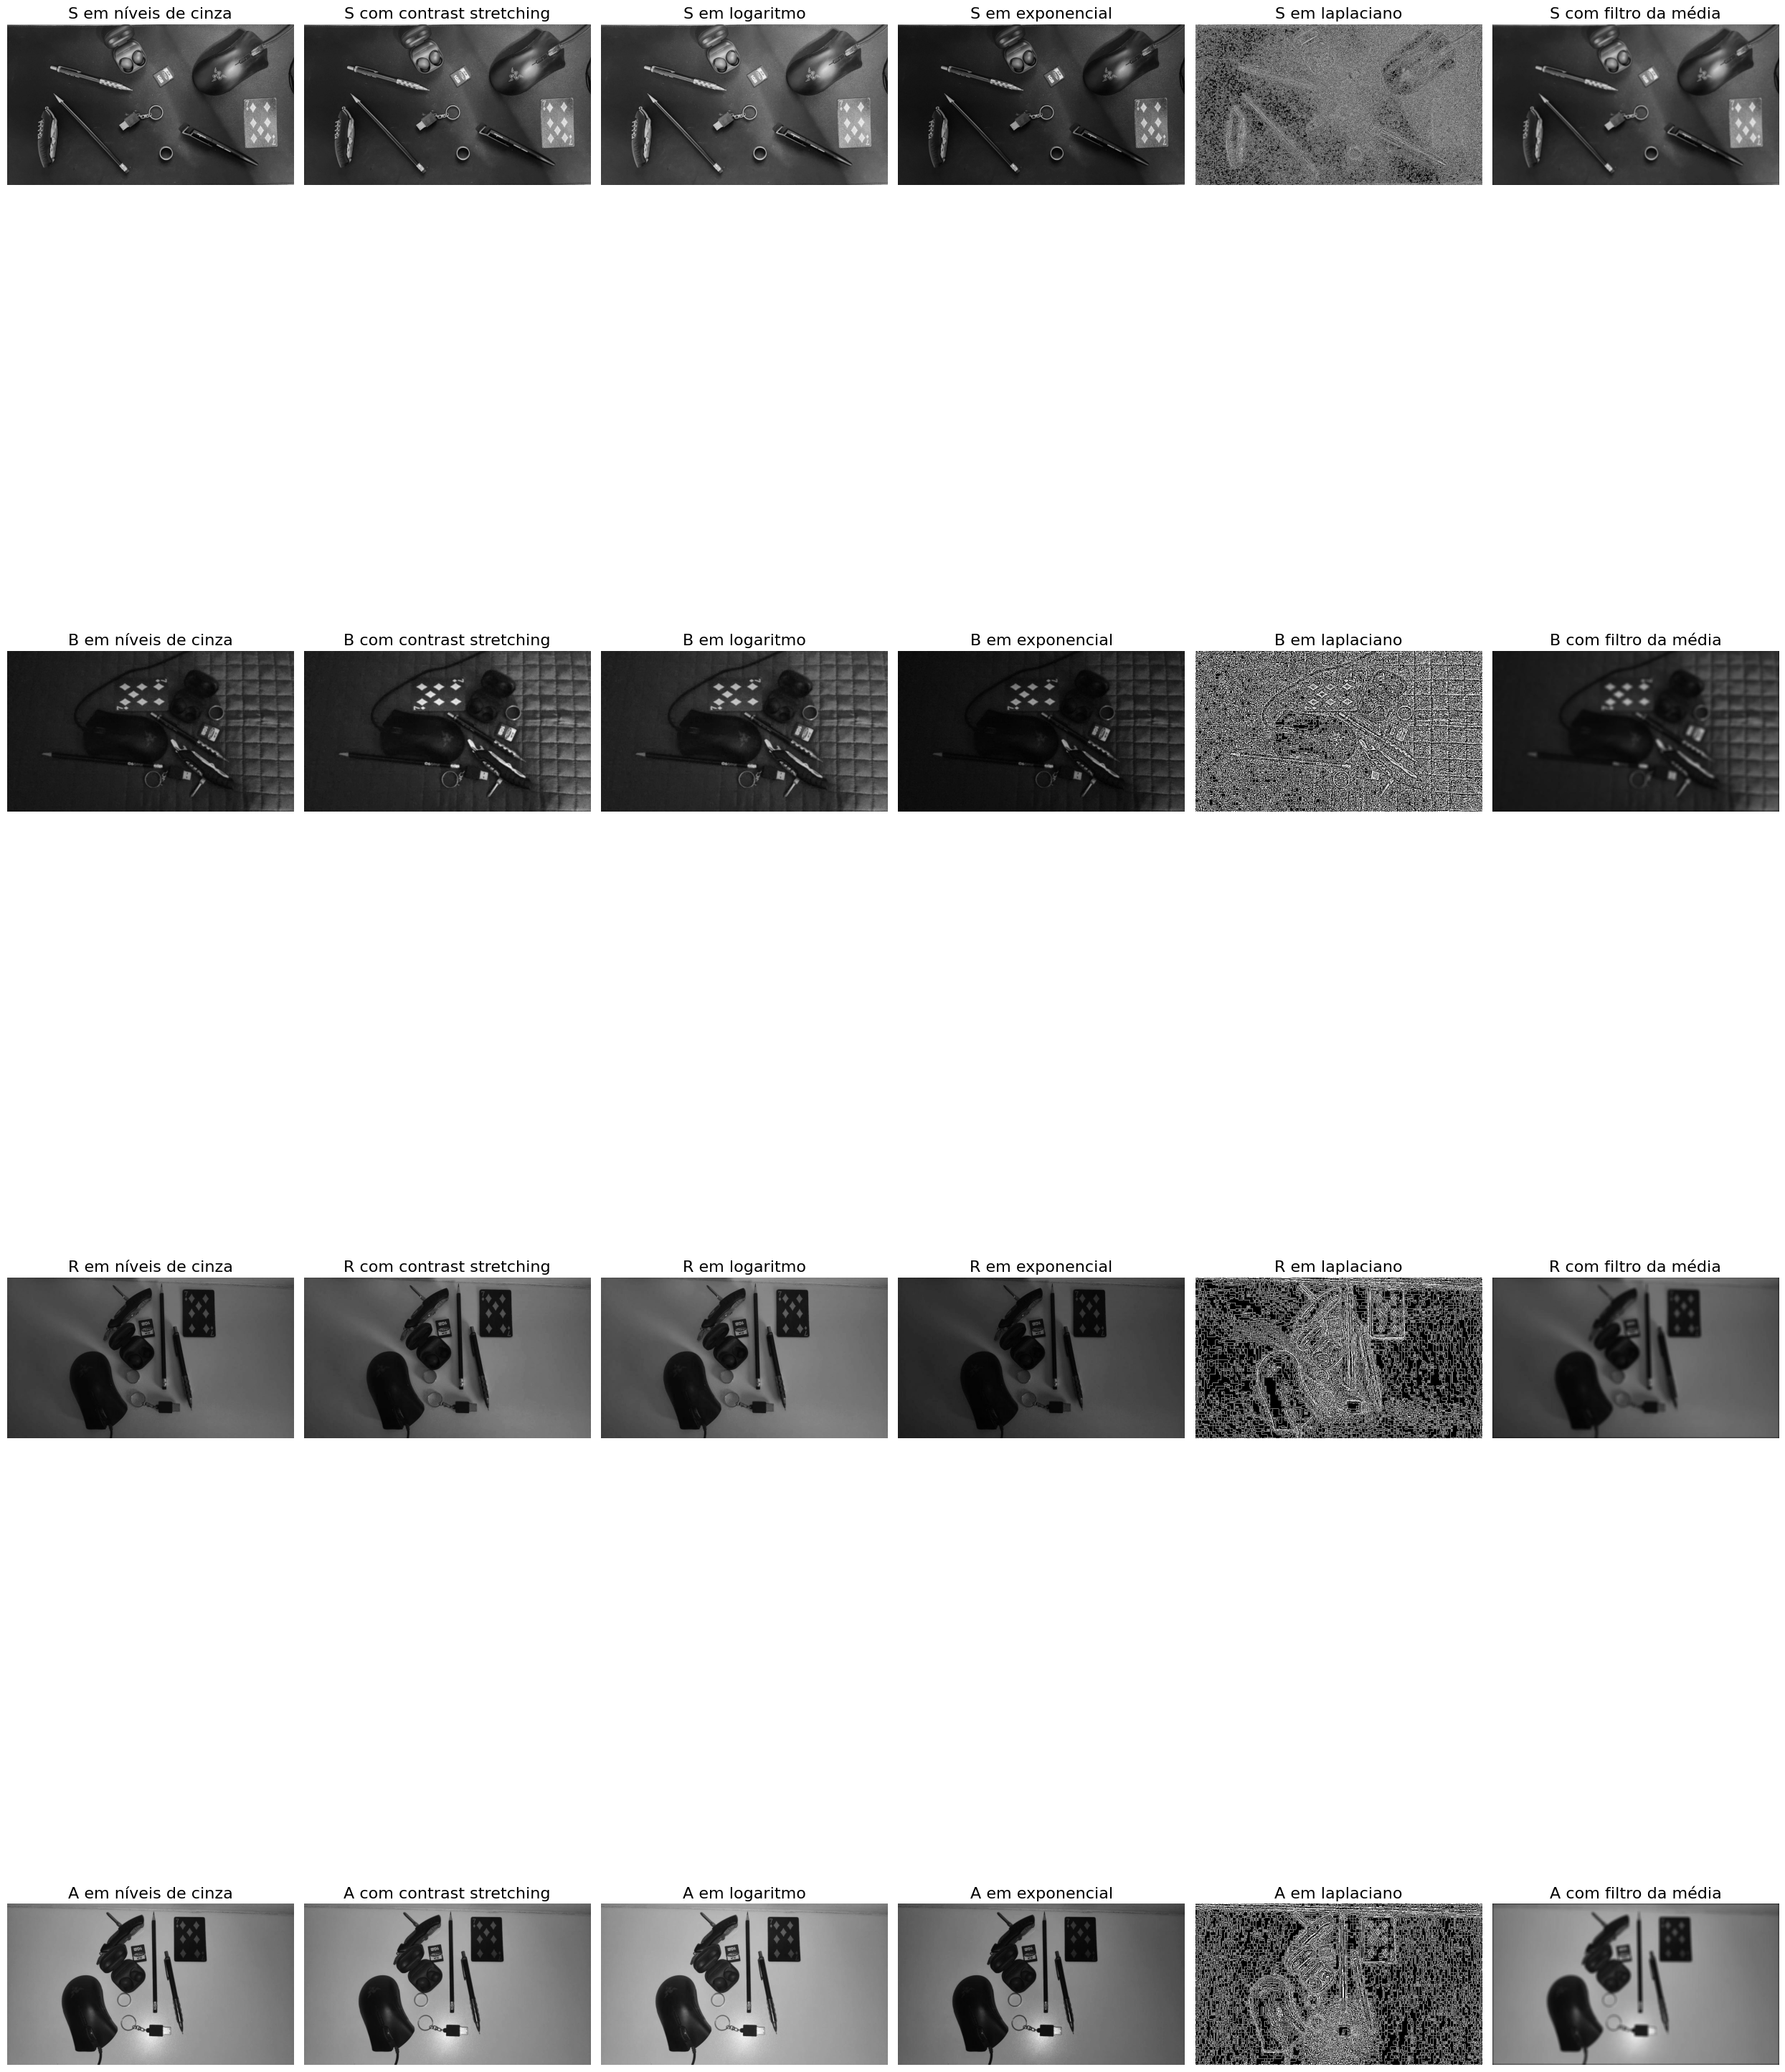

In [147]:
diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs/'
lista_extensoes = ['con', 'log', 'exp', 'lap', 'med']
iluminacoes = pd.read_excel('Metadados_atualizado.xlsx', sheet_name='Iluminacao')

# Sorteando e lendo uma imagem de cada iluminação com todos os filtros:
imagens = {}
list_random = []
for i in range(iluminacoes.shape[0]):
  iluminacao = iluminacoes.iloc[i]['abrv']
  nome_imagem = random.sample(os.listdir(diretorio_final + 'originalGrayDataset/' + "Anel"), 1)[0]
  list_random += [nome_imagem]
  imagens[iluminacao] = [io.imread(diretorio_final + 'originalGrayDataset/' + "Anel" + '/' + nome_imagem)]
  for ext in lista_extensoes:
    imagens[iluminacao].append(io.imread(diretorio_final + 'augmentedDataset/' + "Anel" + '/' + ext + '/' + nome_imagem[:nome_imagem.index(".")] + '-' + ext + '.jpg'))

# Plot:
titulos = [" em níveis de cinza", " com contrast stretching", " em logaritmo", " em exponencial", " em laplaciano", " com filtro da média"]

fig, axs = plt.subplots(iluminacoes.shape[0], len(titulos), figsize=(25, 40))
for i in range(iluminacoes.shape[0]):
  iluminacao = iluminacoes.iloc[i]['abrv']
  for j in range(len(titulos)):
    if j == 0:
      axs[i,j].imshow(imagens[iluminacao][j], cmap='gray', vmin=0, vmax=255)
    else:
      axs[i,j].imshow(imagens[iluminacao][j], cmap='gray', vmin=0, vmax=255)
    axs[i,j].set_title(iluminacao + titulos[j], fontsize=16)
    axs[i,j].axis('off')
plt.tight_layout()
plt.show()

Rodando agora as mesmas imagens, mas para o Dataset normalizado, obtemos as seguintes imagens:

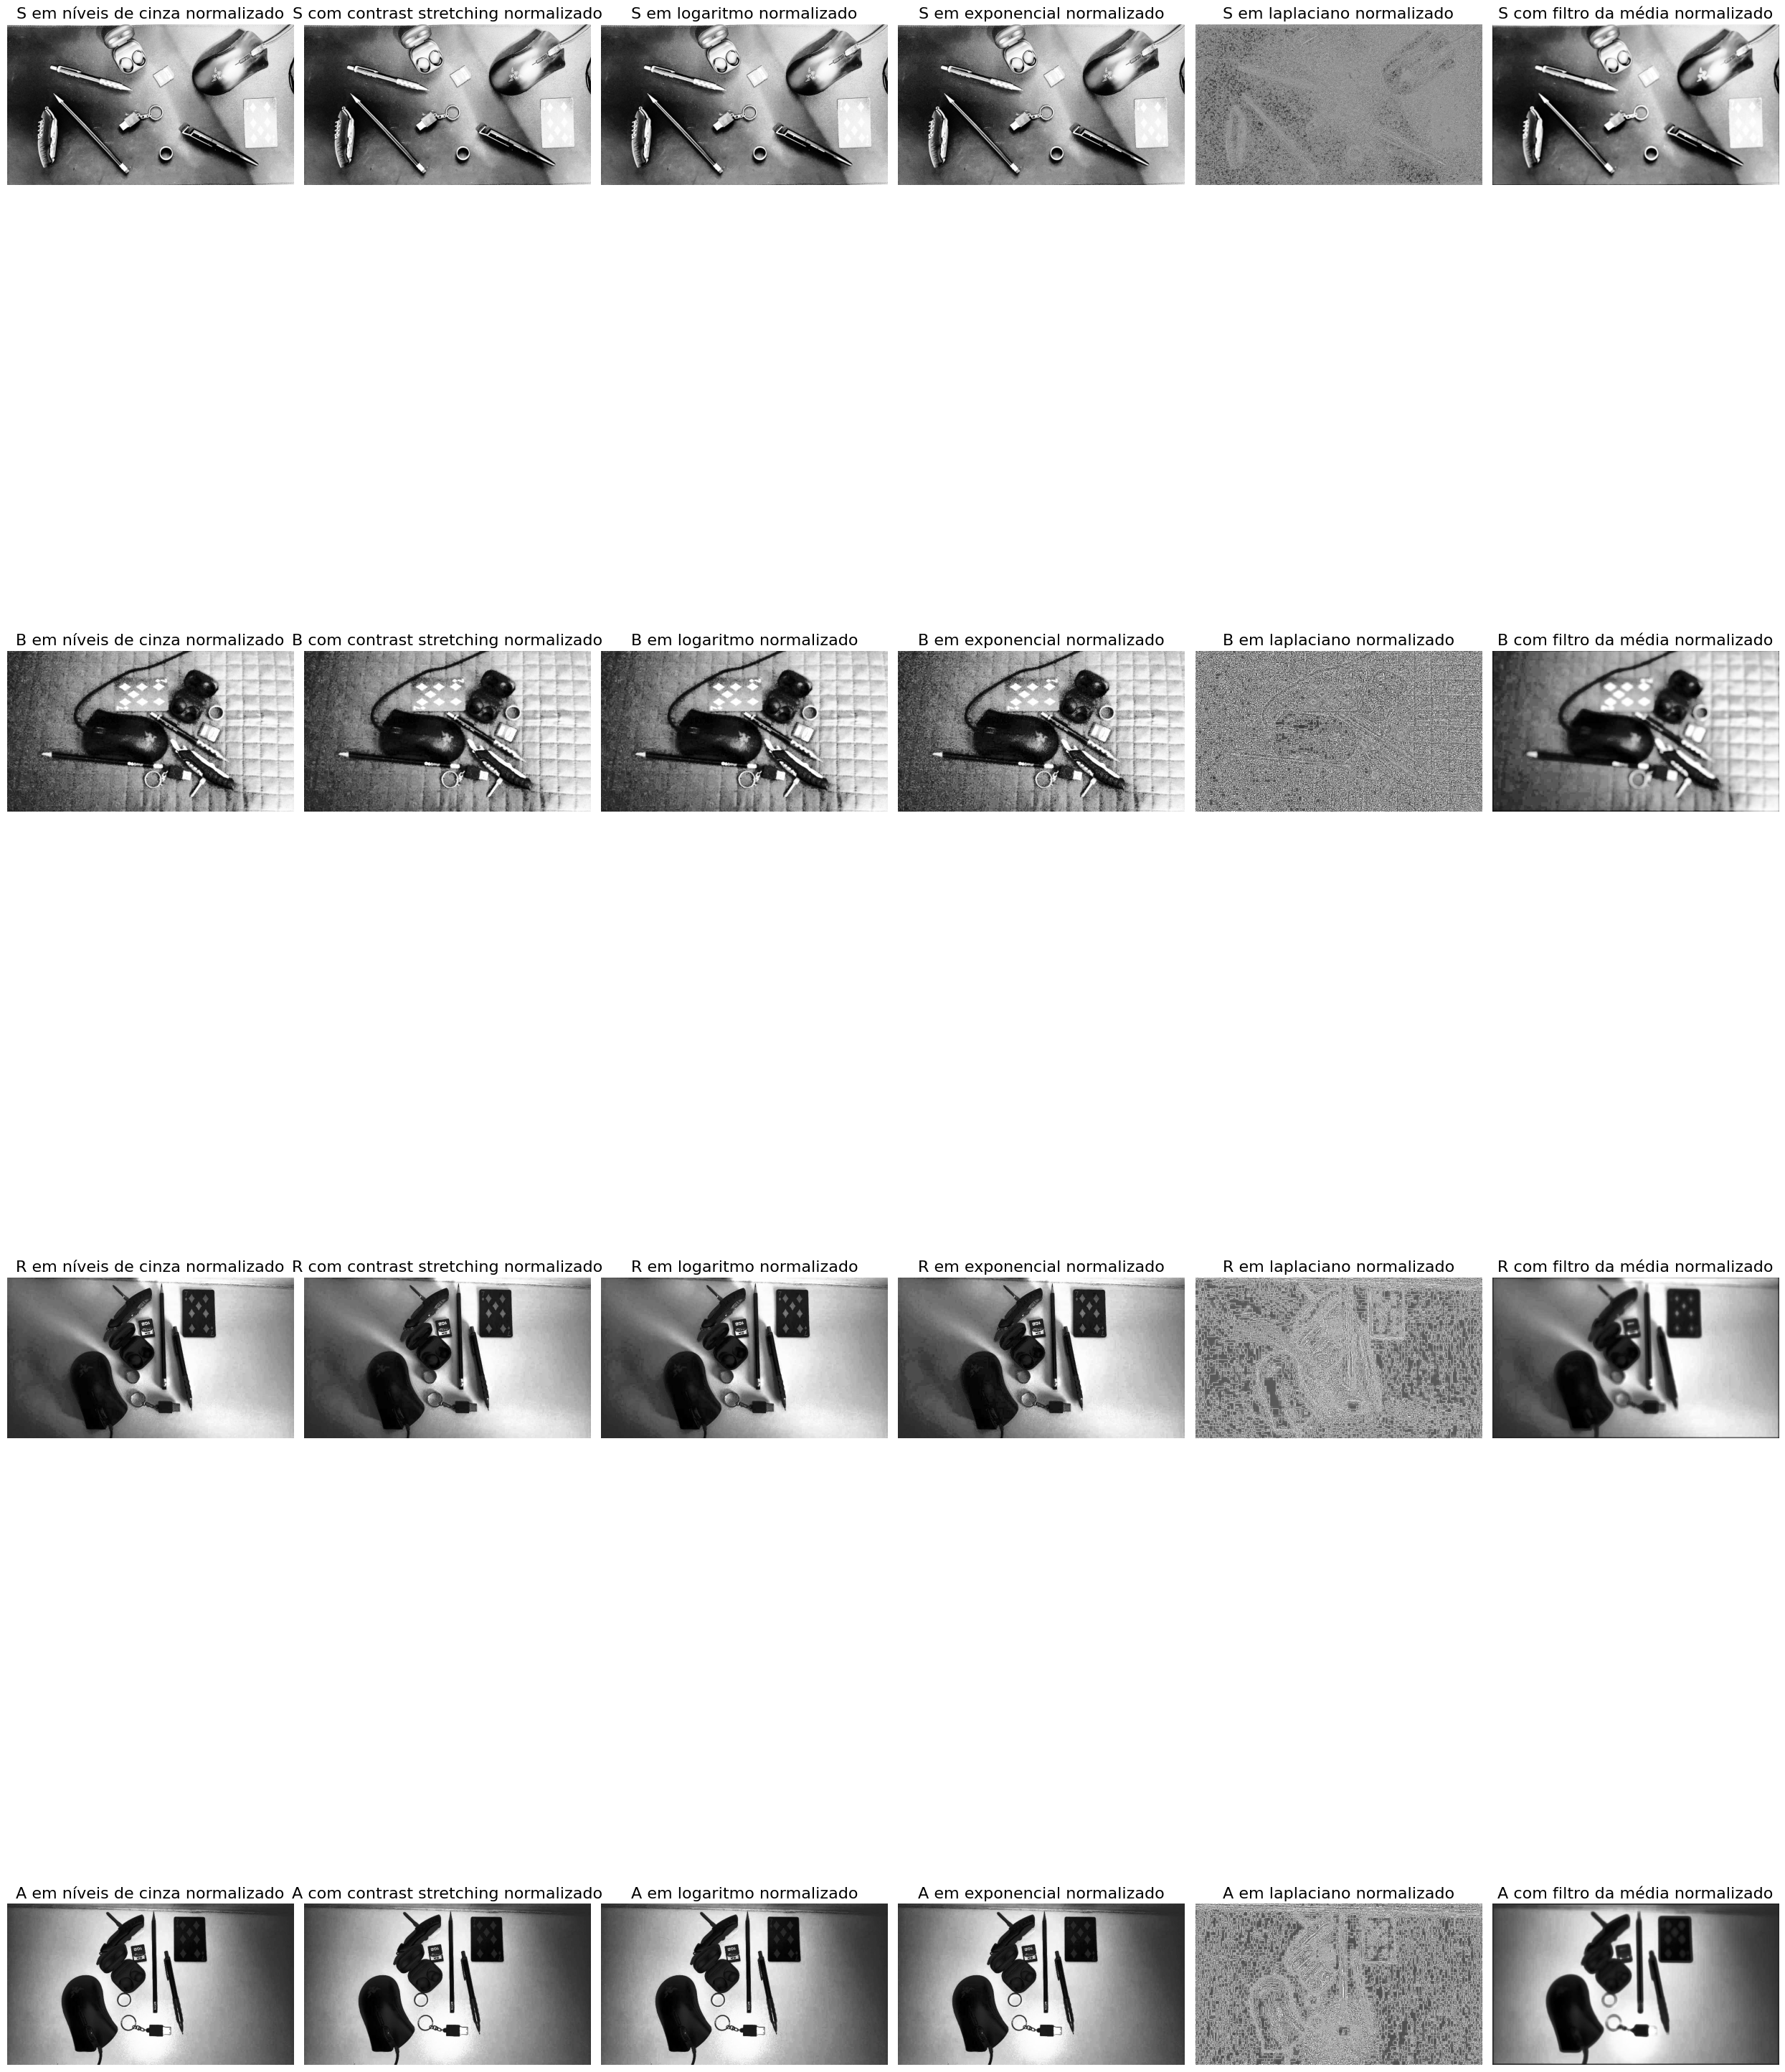

In [148]:
diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs/'
lista_extensoes = ['con', 'log', 'exp', 'lap', 'med']
iluminacoes = pd.read_excel('Metadados_atualizado.xlsx', sheet_name='Iluminacao')

# Sorteando e lendo uma imagem de cada iluminação com todos os filtros:
imagens = {}
for i in range(iluminacoes.shape[0]):
  iluminacao = iluminacoes.iloc[i]['abrv']
  nome_imagem = diretorio_final + 'normalizedDataset/' + "Anel"
  imagens[iluminacao] = [io.imread(nome_imagem + '/cin/' + list_random[i][:-4] + '-norm.jpg')]
  for ext in lista_extensoes:
    nome_imagem1 = nome_imagem + '/' + ext + '/' + list_random[i][:-4]
    imagens[iluminacao].append(io.imread(nome_imagem1 + '-' + ext + '-norm.jpg'))

# Plot:
titulos = [" em níveis de cinza normalizado", " com contrast stretching normalizado", " em logaritmo normalizado", " em exponencial normalizado", " em laplaciano normalizado", " com filtro da média normalizado"]

fig, axs = plt.subplots(iluminacoes.shape[0], len(titulos), figsize=(25, 40))
for i in range(iluminacoes.shape[0]):
  iluminacao = iluminacoes.iloc[i]['abrv']
  for j in range(len(titulos)):
    if j == 0:
      axs[i,j].imshow(imagens[iluminacao][j], cmap='gray', vmin=0, vmax=255)
    else:
      axs[i,j].imshow(imagens[iluminacao][j], cmap='gray', vmin=0, vmax=255)
    axs[i,j].set_title(iluminacao + titulos[j], fontsize=16)
    axs[i,j].axis('off')
plt.tight_layout()
plt.show()

# 5. Conclusões obtidas dada a comparação das imagens plotadas:
Observa-se que, após a realização da normalização, as imagens de quase todas as classes se mostraram mais intrepretáveis e fáceis de visualizar (principalmente as imagens com iluminações mais baixas), com um maior contraste  quando comparadas as imagens não normalizadas. Vale ressaltar que, as imagens onde foi aplicado o laplaciano tiveram a vizualização bem prejudicada com a realização da normalização, mas isso era de se esperar, visto que, sem a normalização, essas imagens já estavam com visualização inferiror quando comparadas aos outros métodos (o que indica um possível equivoco na implementação desse função).

## Tempo de execução do notebook ##

In [149]:
t11 = time()
tempo_em_horas = (t11-t00)//3600
sobra = (t11-t00)%3600
tempo_em_minutos = sobra//60
tempo_em_segundos = sobra%60
print(f"Tempo de execução do notebook: {tempo_em_horas} h {tempo_em_minutos} min {tempo_em_segundos} s")

Tempo de execução do notebook: 0.0 h 17.0 min 16.864623069763184 s
